In [3]:
!pip install tensorflow

In [4]:
!pip install opencv-python-headless
!pip install scikit-image

# 1. 라이브러리 선언

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
import numpy as np
from skimage import feature, exposure
from google.colab.patches import cv2_imshow
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 데이터 준비


In [ ]:
# 경계 상자 좌표를 라벨링 데이터에서 추출합니다.
bbox = labeling_data['annotations'][0]['bbox']
x, y, w, h = bbox

# 알약 이미지를 로드합니다.
pill_image_path = '/mnt/data/' + labeling_data['images'][0]['file_name']
pill_image = cv2.imread(pill_image_path, cv2.IMREAD_COLOR)

# 알약 이미지에서 알약 부분을 잘라냅니다.
pill_cropped = pill_image[y:y+h, x:x+w]

# 잘라낸 이미지의 크기를 확인하고, 필요한 경우 크기를 조정합니다.
pill_resized = cv2.resize(pill_cropped, (227, 227))

# 잘라낸 알약 이미지를 시각화합니다.
plt.imshow(cv2.cvtColor(pill_resized, cv2.COLOR_BGR2RGB))
plt.show()

# 2. Data 전처리

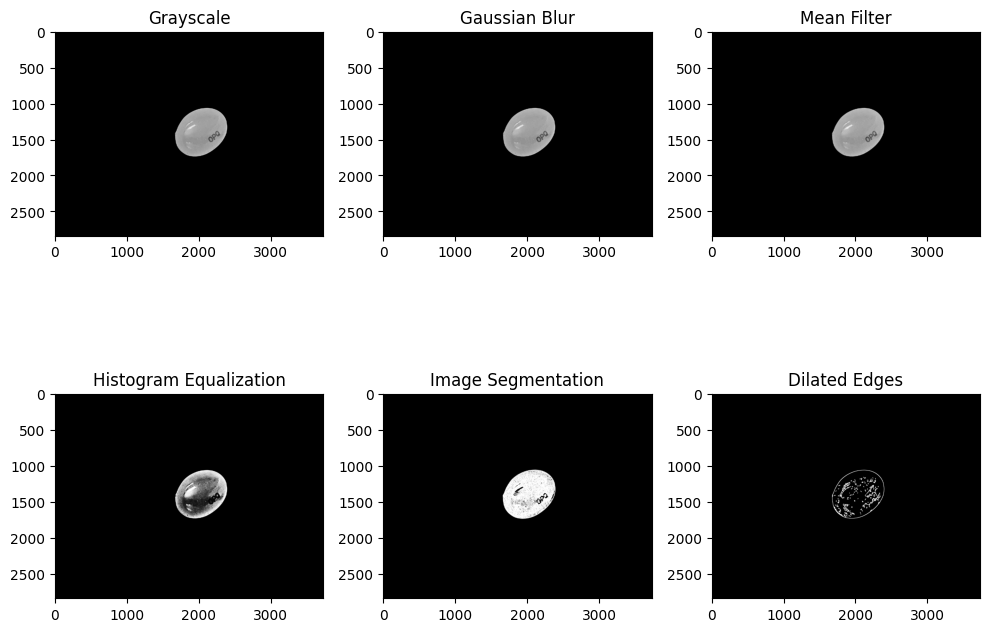

In [8]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# 이미지 로드: 이 경로는 실제 이미지 파일 경로로 대체해야 합니다.
image_path = '/content/drive/MyDrive/Pill\'s_Good/Data/test/29002/IMG_20201202_163857.png'
image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # 컬러 이미지로 로드

# 그레이스케일로 변환
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 노이즈 제거: 가우시안 블러
blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

# 이미지 평활화: 평균 필터
kernel = np.ones((5, 5), np.float32) / 25
smoothed_image = cv2.filter2D(blurred_image, -1, kernel)

# 명암 대비 정규화: 히스토그램 평활화
equalized_image = cv2.equalizeHist(smoothed_image)

# 에지 검출: 소벨 필터
sobelx = cv2.Sobel(equalized_image, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(equalized_image, cv2.CV_64F, 0, 1, ksize=5)
sobel_edges = cv2.magnitude(sobelx, sobely)

# Sobel 에지 결과를 8비트 이미지로 변환합니다.
sobel_edges_8u = cv2.convertScaleAbs(sobel_edges)

# 이미지 세분화: 이진화를 위해 8비트 이미지 사용
_, binary_image = cv2.threshold(sobel_edges_8u, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 에지 검출: 캐니 에지
canny_edges = cv2.Canny(equalized_image, 100, 200)

# 에지 확장: 이미지 확대 (Dilation)
dilation_kernel = np.ones((5, 5), np.uint8)
dilated_image = cv2.dilate(canny_edges, dilation_kernel, iterations=1)

# 결과 시각화
plt.figure(figsize=(10, 8))
plt.subplot(231), plt.imshow(gray_image, cmap='gray'), plt.title('Grayscale')
plt.subplot(232), plt.imshow(blurred_image, cmap='gray'), plt.title('Gaussian Blur')
plt.subplot(233), plt.imshow(smoothed_image, cmap='gray'), plt.title('Mean Filter')
plt.subplot(234), plt.imshow(equalized_image, cmap='gray'), plt.title('Histogram Equalization')
plt.subplot(235), plt.imshow(binary_image, cmap='gray'), plt.title('Image Segmentation')
plt.subplot(236), plt.imshow(dilated_image, cmap='gray'), plt.title('Dilated Edges')
plt.tight_layout()
plt.show()


In [7]:
image = cv2.imread(image_path, cv2.IMREAD_COLOR)
print(image)  # 이미지 객체를 출력하여 None인지 확인합니다.


None


In [9]:
# 이미지를 모델 입력 크기로 리사이즈합니다.
resized_images = [cv2.resize(img, (227, 227)) for img in [binary_image, dilated_image]]

# 이미지들을 하나의 배치로 결합합니다.
# 추가 차원을 추가하여 4D 텐서로 만듭니다: (samples, height, width, channels)
# 채널을 복사하여 3개로 만듦으로써 RGB 차원을 확장합니다.
batch_images = np.stack(resized_images, axis=0)
batch_images = np.repeat(batch_images, 3, axis=-1)

# Model 정의

In [10]:
# CNN 모델 정의
def create_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((3, 3), strides=(2, 2)),
        layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
        layers.MaxPooling2D((3, 3), strides=(2, 2)),
        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((3, 3), strides=(2, 2)),
        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# 모델 생성
input_shape = (227, 227, 3)  # 예시 입력 크기
num_classes = 2  # 올바른 약품 이미지, 잘못된 약품 이미지의 두 클래스
cnn_model = create_cnn(input_shape, num_classes)

# 컴파일 설정
cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# 모델 요약
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 384)       1

# 학습

In [ ]:
# 모델 훈련
cnn_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# 모델 평가
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)

# 예측
predictions = cnn_model.predict(X_test)

# 테스트(firebase storage에서 데이터 불러오기)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# 평가

In [ ]:
# 테스트 데이터셋에 대한 예측을 수행합니다.
y_pred = knn.predict(X_test_features)

# 분류 결과를 평가합니다.
print(classification_report(y_test, y_pred))